# Test

In [ ]:
#hide
%load_ext autoreload
%autoreload 2

In [ ]:
import torch
import torch.nn.functional as F
import glob 
from PIL import Image
from torchvision import transforms
import torchvision.transforms.functional as TF
import os
import numpy as np

from RSF.RSF import *
from RSF.utils import *

In [ ]:
os.chdir('../')
os.getcwd()

'/home/me/github/RSF'

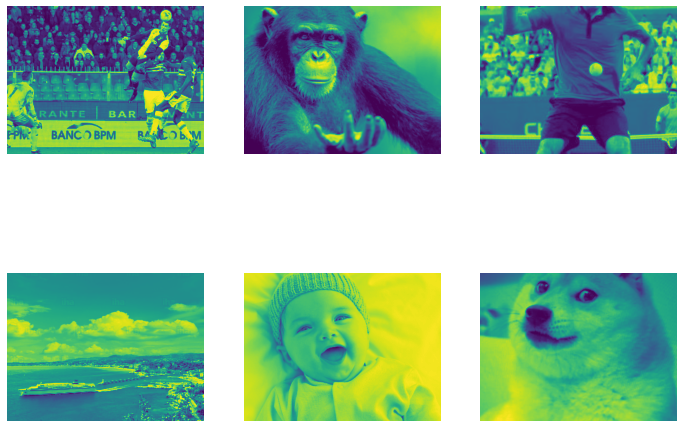

In [ ]:

images = [Image.open(path) for path in glob.glob('./data/samples/**.jpg', recursive=True)]
c, h, w = 1, 300, 400
image_transform = transforms.Compose([
    transforms.Grayscale(),
    transforms.ToTensor(),
    transforms.Resize(w),
    transforms.CenterCrop((h, w))
])

X = torch.stack([image_transform(im) for im in images]) 
plot_images(X)

In [ ]:
P[:,:,:,:1].max()

tensor(348.3000)

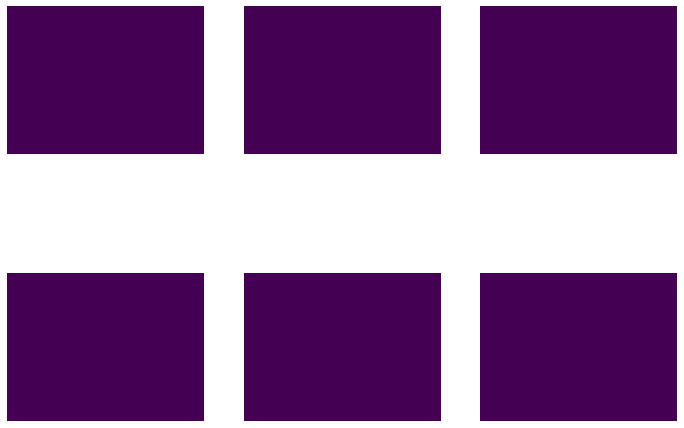

In [ ]:
P = []
for Xnp in X.numpy().astype(np.float64).squeeze():
    H, W = Xnp.shape
    I1 = cvtIntegralImage(Xnp)                 # calculate integral image
    P1 = cvtIntegralImage(Xnp**2)    # calculate integral image of squared pixel value
    nR = 75    # filter size parameter

    P.append(cvtCombSimpRectFilter(I1,P1,nR))   # apply vertical and horizontal rectangular filters
P = np.stack(P)
plot_images(P[:,:,:,:1])

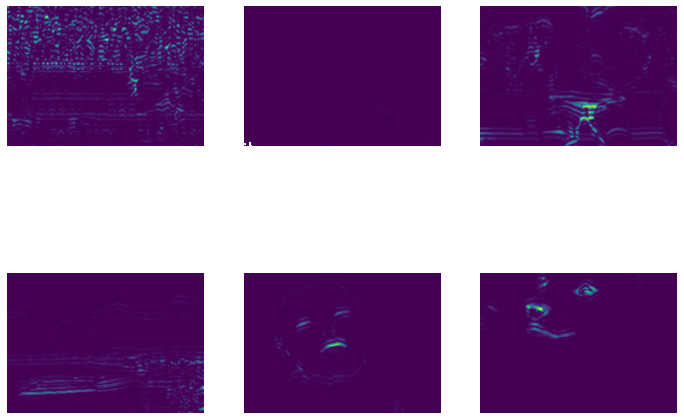

In [ ]:
def integral_image(X): # For batch
    for i in range(1, X.ndim):
        X = X.cumsum(i)
    return X

def RecSum(SAT, h, w):
    W = [[1,-1],[-1,1]]
#     left, right, top, bottom = 0, w, 0, h
#     SAT = F.pad(SAT, (left, right, top, bottom), mode='replicate')
    return conv2d(SAT, W, dilation=(h, w))


def integral_image(X, angle):
    X_rot = TF.rotate(X, angle=-angle, expand=True)
    for i in range(1, X_rot.ndim):
        X_rot = X_rot.cumsum(i)
    return X_rot

def conv2d(X, W, normalize_weights=True, **kwargs):
    X = torch.FloatTensor(X)
    W = torch.FloatTensor(W)
    
    # Do stuff on the input tensor
    if X.ndim==2:
        X = X.view(1, 1, *X.shape)
    elif X.ndim==3:
        X = X.view(1, *X.shape)
    else:
        assert X.ndim==4

    # Do stuff on the weights
    c = X.shape[1]
    h, w = W.shape[-2:]
    W = W.view(1, 1, h, w).repeat(c,1,1,1)
    c = X.shape[1]
    
    # Do the convolution
    Y = F.conv2d(X, W.flip(2).flip(3), groups=c, **kwargs)
    return Y

angle=0
t = 5
# H, W = X.shape[-2:]

II = integral_image(X, angle=angle) 
t_area_sum = RecSum(F.pad(II, (0, 0, 0, 0), mode='constant'), t, t)

II_sq = integral_image(torch.pow(X, 2), angle=angle) 
t_area_sum_sq = RecSum(F.pad(II_sq, (0, 0, 0, 0), mode='constant'), t, t)

P1_w = np.array([[0],[1],[1],[0]]) / 2
P1 = conv2d(t_area_sum, P1_w, dilation=(t))

P2_w = np.array([[1],[0],[0],[1]]) / 2
P2 = conv2d(t_area_sum, P2_w, dilation=(t))

P_w = np.array([[1],[1],[1],[1]]) / 4
P = conv2d(t_area_sum, P_w, dilation=(t))
Psq = conv2d(t_area_sum_sq, P_w, dilation=(t))

N1 = t*2 * t
N2 = t*t
N = N1 + N2

Sb = (N1/N)*torch.pow((P1 - P),2) + (N2/N)*torch.pow((P2 - P),2)
St = torch.pow(P, 2) - Psq

sepmap = Sb/St
sepmap[sepmap<0] = 0
plot_images(sepmap)

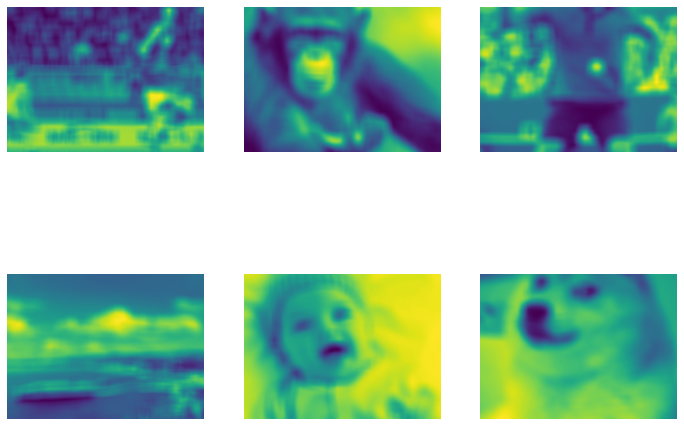

torch.Size([6, 1, 280, 380])


In [ ]:
t_area_sum = RecSum(F.pad(II, (0, 0, 0, 0), mode='constant'), t, t)
# print(t_area_sum[:, 0, 0, 0], II[:, 0,0,0])
# print(t_area_sum[:, 0, 0, 20], II[:, 0,0,20])
plot_images(t_area_sum)
print(t_area_sum.shape)

In [ ]:
sepmap.shape

torch.Size([6, 1, 280, 395])

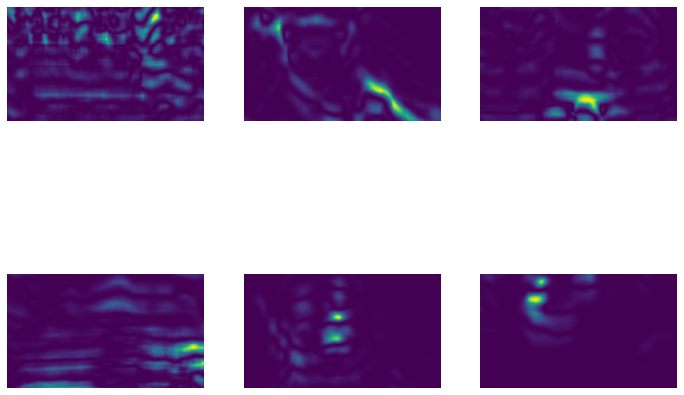

In [ ]:
angle=0
t = 20
# H, W = X.shape[-2:]

II = integral_image(X, angle=angle) 
t_area_sum = RecSum(F.pad(II, (0, 0, 0, 0), mode='constant'), t, t)

II_sq = integral_image(torch.pow(X, 2), angle=angle) 
t_area_sum_sq = RecSum(F.pad(II_sq, (0, 0, 0, 0), mode='constant'), t, t)

P1_w = np.array([[0],[1],[1],[0]]) / 2
P1 = conv2d(t_area_sum, P1_w, dilation=(t))

P2_w = np.array([[1],[0],[0],[1]]) / 2
P2 = conv2d(t_area_sum, P2_w, dilation=(t))

P_w = np.array([[1],[1],[1],[1]]) / 4
P = conv2d(t_area_sum, P_w, dilation=(t))
Psq = conv2d(t_area_sum_sq, P_w, dilation=(t))

N1 = t*2 * t
N2 = t*t
N = N1 + N2

Sb = (N1/N)*torch.pow((P1 - P),2) + (N2/N)*torch.pow((P2 - P),2)
St = torch.pow(P, 2) - Psq

sepmap = Sb/St
sepmap[sepmap<0] = 0
plot_images(sepmap)

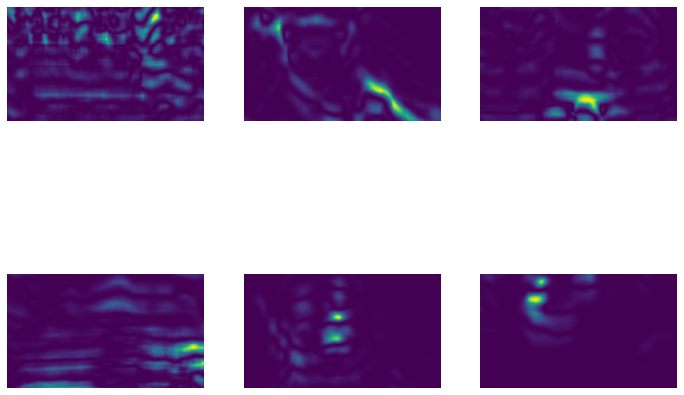

torch.Size([6, 1, 220, 380])


In [ ]:
N1 = t*2 * t
N2 = t*t
N = N1 + N2
Sb = (N1/N)*torch.pow((P1 - P),2) + (N2/N)*torch.pow((P2 - P),2)
# plot_images(Sb)

St = torch.pow(P, 2) - Psq
# plot_images(St)

sepmap = Sb/St
# sepmap[sepmap>0] = 0
plot_images(sepmap)
print(sepmap.shape)

In [ ]:
sepmap.min()

tensor(-0.9406)

In [ ]:
P1 = RecSum(F.pad(II, (t2, t2, 0, 0), mode='replicate'), t1*2, t3)
P1 = TF.crop(P1, top=t2, left=0, height=out_H, width=out_W)
print(P1.shape)
# plot_images(P1)

P2_1 = F.pad(II, (0, 0, 0, t2+t1*2), mode='replicate')
P2_1 = RecSum(P2_1, t2, t3)
P2_1 = TF.crop(P2_1, top=t2, left=0, height=out_H, width=out_W)
print(P2_1.shape)
# plot_images(P2_1)

P2_2 = F.pad(II, (0, 0, t2+t1*2, 0), mode='replicate')
P2_2 = RecSum(P2_2, t2, t3)
P2_2 = TF.crop(P2_2, top=t1*2+t2, left=0, height=out_H, width=out_W)
print(P2_2.shape)
# plot_images(P2_2)

P2 = P2_1 + P2_2
# plot_images(P2)

P = RecSum(II, t1*2+t2*2, t3)
print(P.shape)
# plot_images(P)


Psq = RecSum(integral_image(t.pow(X,2), angle=angle) , t1*2+t2*2, t3)
print(Psq.shape)
# plot_images(Psq)

N1 = t1*2 * t3
N2 = t2*t3
N = N1 + N2
Sb = (N1/N)*t.pow((P1 - P),2) + (N2/N)*t.pow((P2 - P),2)
# plot_images(Sb)

St = Psq - t.pow(P, 2)
# plot_images(St)

sepmap = Sb/St
plot_images(sepmap)

In [ ]:
def sep_filter(X, t1, t2, t3, angle):
    def integral_image(X): # For batch
        for i in range(1, X.ndim):
            X = X.cumsum(i)
        return X

    def RecSum(SAT, h, w):
        W = [[1,-1],[-1,1]]
        return conv2d(SAT, W, dilation=(h, w))

    def integral_image(X, angle):
        X_rot = TF.rotate(X, angle=-angle, expand=True)
        for i in range(1, X_rot.ndim):
            X_rot = X_rot.cumsum(i)
        return X_rot


    II = integral_image(X, angle=angle) 
    H, W = II.shape[-2:]
    out_H = H - (t1*2 + t2*2) 
    out_W = W - (t3) 
    print(H, W, out_H, out_W)

    P1 = RecSum(F.pad(II, (0, 0, t2, t2), mode='replicate'), t1*2, t3)
    P1 = TF.crop(P1, top=t2, left=0, height=out_H, width=out_W)
    print(P1.shape)

    P2_1 = F.pad(II, (0, 0, 0, t2+t1*2), mode='replicate')
    P2_1 = RecSum(P2_1, t2, t3)
    P2_1 = TF.crop(P2_1, top=t2, left=0, height=out_H, width=out_W)
    print(P2_1.shape)

    P2_2 = F.pad(II, (0, 0, t2+t1*2, 0), mode='replicate')
    P2_2 = RecSum(P2_2, t2, t3)
    P2_2 = TF.crop(P2_2, top=t1*2+t2, left=0, height=out_H, width=out_W)
    print(P2_2.shape)

    P2 = P2_1 + P2_2

    P = RecSum(II, t1*2+t2*2, t3)
    print(P.shape)


    Psq = RecSum(integral_image(t.pow(X,2), angle=angle) , t1*2+t2*2, t3)
    print(Psq.shape)

    N1 = t1*2 * t3
    N2 = t2*t3
    N = N1 + N2
    Sb = (N1/N)*t.pow((P1 - P),2) + (N2/N)*t.pow((P2 - P),2)

    St = Psq - t.pow(P, 2)

    sepmap = Sb/St
#     II = integral_image(X, angle=angle) 
#     IIsq = integral_image(t.pow(X,2), angle=angle) 

#     P1 = RecSum(F.pad(II, (0, 0, t2, t2), mode='replicate'), t1*2, t3)
#     P2_1 = F.pad(II, (0, 0, 0, t2+t1), mode='replicate')
#     P2_2 = F.pad(II, (0, 0, t2+t1, 0), mode='replicate')
#     P2 = P2_1 + 

#     P = RecSum(II, t1*2+t2*2, t3)
    
#     Psq = RecSum(IIsq, t1*2+t2*2, t3)

#     N1 = t1*2 * t3
#     N2 = t2*t3
#     N = N1 + N2
#     Sb = (N1/N)*t.pow((P1 - P),2) + (N2/N)*t.pow((P2 - P),2)

#     St = Psq - t.pow(P, 2)

#     sepmap = Sb/St
    print(X.shape, sepmap.shape, TF.rotate(sepmap, angle=-angle, expand=True).shape)
    sepmap = TF.center_crop(TF.rotate(sepmap, angle=-angle, expand=True), X.shape[-2:])
    return sepmap

t1, t2, t3 = 15,15,15
angle = 0
sepmap = sep_filter(X, t1, t2, t3, angle)
plot_images(sepmap)

300 400 240 385


TypeError: flip() missing 1 required positional arguments: "dims"

In [ ]:
# def _RecSum(SAT, x1, y1, x2, y2):
#     H, W = SAT.shape[:2]
#     upper_left = SAT[y1-1, x1-1] if y1-1 >= 0 and x1-1 >= 0 else 0
#     lower_left = SAT[y2-1, x1-1] if y2-1 < H and x1-1 >= 0 else 0
#     upper_right = SAT[y1-1, x2-1] if y1-1 >= 0 and x2-1 < W else 0
#     lower_right = SAT[y2-1, x2-1] if y2-1 < H and x2-1 < W else 0
#     return upper_left - lower_left - upper_right + lower_right
#     else:
        
#         R = t.zeros(SAT.shape).permute(2,3,0,1)
#         SAT = SAT.permute(2,3,0,1)
#         H, W = SAT.shape[:2]
        
#         for y in range(H):
#             for x in range(W):
#                 R[y, x] = _RecSum(SAT, x, y, x+w, y+h)
#         return R.permute(2,3,0,1)
